# CNN2D-LSTM con TriEmoMex V2


## Preparación de datos
---

In [92]:
# Importar base de datos
from google.colab import drive
import zipfile

drive.mount('/content/drive') # nos unimos a la nube de drive

#Path de los archivos zip
zip_MESD =    '/content/drive/MyDrive/MESD.zip'
zip_IESC_1 =  '/content/drive/MyDrive/IESC-Child/IESC_p1.zip'
zip_IESC_2 =  '/content/drive/MyDrive/IESC-Child/IESC_p2.zip'
zip_EW =      '/content/drive/MyDrive/EW.zip'

# EmoWisconsin
zip_ref = zipfile.ZipFile(zip_EW, 'r')
zip_ref.extractall('/content/EW')
zip_ref.close()

# MESD
zip_ref = zipfile.ZipFile(zip_MESD, 'r')
zip_ref.extractall('/content/MESD')
zip_ref.close()

# IESC-Child
zip_ref = zipfile.ZipFile(zip_IESC_1,'r')
zip_ref.extractall('/content/IESC')
zip_ref.close()

zip_ref = zipfile.ZipFile(zip_IESC_2,'r')
zip_ref.extractall('/content/IESC/IESC-Child-RN')
zip_ref.close()

!ls

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  EW  IESC  MESD  sample_data


In [93]:
# Importar csv de TriEmoMex V2
import pandas as pd

tem_path = '/content/drive/MyDrive/TriEmoMex_V2.csv'
df = pd.read_csv(tem_path, index_col=0)

print(df.head())
df['emotion'].value_counts()

                                               audio  emotion
0  /content/MESD/Mexican Emotional Speech Databas...        0
1  /content/MESD/Mexican Emotional Speech Databas...        0
2  /content/MESD/Mexican Emotional Speech Databas...        0
3  /content/MESD/Mexican Emotional Speech Databas...        0
4  /content/MESD/Mexican Emotional Speech Databas...        0


0    1000
3    1000
5    1000
7     975
4     724
2     593
1     387
6     120
Name: emotion, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

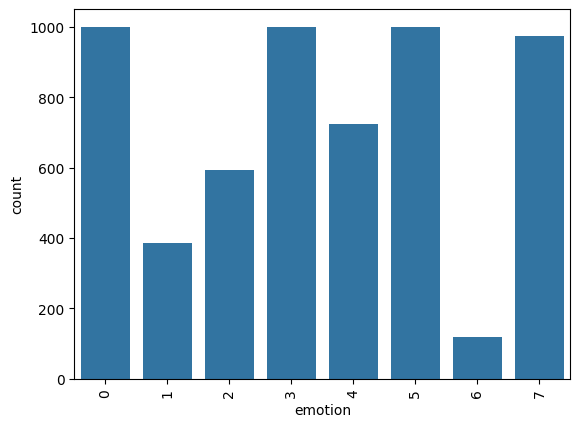

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xticks(rotation='vertical')
sns.countplot(x=df['emotion'])

## **Paso 1. Cargar audios**

In [95]:
sampling_rate = 16000

In [96]:
# Paso 1. Carga los audios
import librosa

def load(data_path, sr=sampling_rate):
  dataset ={'audio':[], 'emotion':[]}
  # Iterar sobre cada archivo
  for i in range(len(data_path)):
    # Guardar la ruta y la emoción
    audio_path = data_path['audio'][i]
    emotion = data_path['emotion'][i]
    # Cargar
    sound,sr = librosa.load(audio_path,sr=sr)
    dataset['audio'].append(sound)
    dataset['emotion'].append(emotion)
  return dataset

In [97]:
dataset = load(df)

In [98]:
print(len(dataset['emotion']))

5799


## **Paso 2. Separar por clases al dataset**

Dado que el porcentaje de D.A. que realizaremos es diferente para cada clase, es buena idea separar.


In [99]:
def get_dataset_class(ds, target_label):
  dataset_class = {'audio':[], 'emotion':[]}

  for i,audio in enumerate(ds['audio']):
    if ds['emotion'][i] == target_label:
      dataset_class['audio'].append(audio)
      dataset_class['emotion'].append(target_label)

  print(str(target_label) + (' --> ') + str(len(dataset_class['emotion'])))
  return dataset_class

In [100]:
tristeza_ds = get_dataset_class(dataset, 1)
enojo_ds = get_dataset_class(dataset, 2)
miedo_ds = get_dataset_class(dataset, 4)
desprecio_ds = get_dataset_class(dataset, 6)
ninguno_ds = get_dataset_class(dataset, 7)

1 --> 387
2 --> 593
4 --> 724
6 --> 120
7 --> 975


## **Paso 3. Data Augmentation**

In [101]:
# Display random sample (verifiación del estado data augmentation)
from IPython.display import Audio

def display_random_sample(ds, emotion = 'emotion', sampling_rate=sampling_rate):
  random_index = np.random.choice(len(ds['emotion']))
  print(f'índice: ', random_index)
  emotion = ds['emotion'][random_index]
  audio = ds['audio'][random_index]
  plt.figure(figsize=(8,4))
  librosa.display.waveshow(audio,sr=sampling_rate)
  plt.title(f'Waveform for emotion {emotion}')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()
  display(Audio(audio,rate=sampling_rate))

def display_sample(audio, title='Sample', sampling_rate=sampling_rate):
  plt.figure(figsize=(8,4))
  librosa.display.waveshow(audio,sr=sampling_rate)
  plt.title(title)
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()
  display(Audio(audio,rate=sampling_rate))

In [102]:
import numpy as np

# Agregar al dataset
def add_to_dataset(dsf):
  global dataset
  print('Antes:', len(dataset['audio']))
  for i in range(len(dsf['emotion'])):
    dataset['emotion'].append(dsf['emotion'][i])
    dataset['audio'].append(dsf['audio'][i])
  print('Después', len(dataset['audio']))

# 1. N O I S E  A D D I T I O N
# El ruido se basa en la desviación estándar del audio
def noise(ds, num_audios,noise_factor=0.050):
  print('- Noise addition -')
  noise_dataset = {'audio':[], 'emotion':[]}
  random_indices = np.random.choice(len(ds['emotion']), num_audios,
                                    replace=False)
  emotions = [ds['emotion'][i] for i in random_indices]
  audios = [ds['audio'][i] for i in random_indices]

  for i in range(len(audios)):

    noise = np.random.normal(0,audios[i].std(), audios[i].size)
    augmented_signal = audios[i]+(noise*noise_factor)

    noise_dataset['emotion'].append(emotions[i])
    noise_dataset['audio'].append(augmented_signal)


  #print(len(noise_dataset['emotion']))
  #print(noise_dataset['emotion'][0])

  add_to_dataset(noise_dataset)
  display_random_sample(noise_dataset, emotion=noise_dataset['emotion'])
  return

# 2. P I T C H   S H I F T I N G
# Utilizaremos 'pitch_shift_variable'
def pitch_shift(ds,num_audios,sr=sampling_rate,min_pitch=-4,max_pitch=4,n_segments=5):
  print('- Pitch-Shifting addition -')
  ps_dataset = {'audio':[],'emotion':[]}

  random_indices = np.random.choice(len(ds['emotion']),num_audios,replace=False)
  emotions = [ds['emotion'][i] for i in random_indices]
  audios = [ds['audio'][i] for i in random_indices]

  for i in range(len(audios)):

    segment_length = len(audios[i]) // n_segments
    pitch_shifted_audio = np.array([])

    for i in range(n_segments):
      # Extraer el segmento
      start = i*segment_length
      end = start + segment_length if i<n_segments - 1 else len(audios[i])
      segment = audios[i][start:end]
      # Aplicar un cambio de tono aleatorio
      pitch_shift_factor = np.random.uniform(min_pitch,max_pitch)
      shifted_segment = librosa.effects.pitch_shift(segment,sr=sr,
                                                    n_steps=pitch_shift_factor)
      # Concatenar el segmento modificado
      pitch_shifted_audio = np.concatenate((pitch_shifted_audio, shifted_segment))

    ps_dataset['audio'].append(pitch_shifted_audio)
    ps_dataset['emotion'].append(emotions[i])

  add_to_dataset(ps_dataset)
  display_random_sample(ps_dataset, emotion=ps_dataset['emotion'])
  return

# 3. T I M E   S T R E T C H I N G
# Utilizaremos 'time_stretching_2' con factor variable
def time_stretching(ds,num_audios,sr=sampling_rate):
  print('- Time stretching addition -')
  ts_dataset = {'audio':[],'emotion':[]}
  random_indices = np.random.choice(len(ds['emotion']),num_audios,replace=False)
  emotions = [ds['emotion'][i] for i in random_indices]
  audios = [ds['audio'][i] for i in random_indices]

  for i in range(len(audios)):
    stretch_factor = np.random.uniform(0.6,1.2)
    audio_stretch = librosa.effects.time_stretch(audios[i],rate=stretch_factor)

    ts_dataset['audio'].append(audio_stretch)
    ts_dataset['emotion'].append(emotions[i])

  add_to_dataset(ts_dataset)
  display_random_sample(ts_dataset, emotion=ts_dataset['emotion'])
  return

- Noise addition -
Antes: 5799
Después 5807
índice:  0


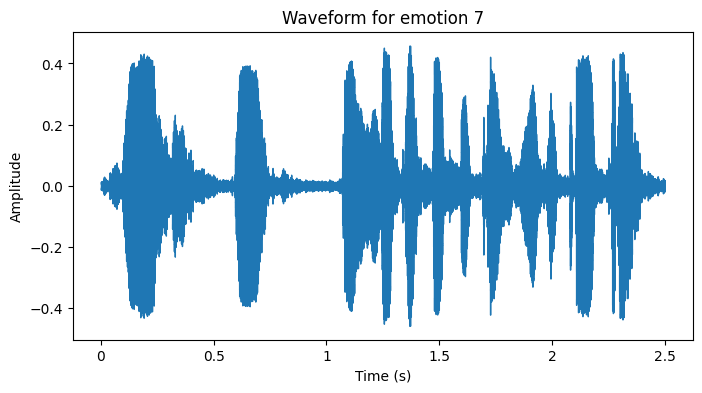

- Noise addition -
Antes: 5807
Después 5899
índice:  64


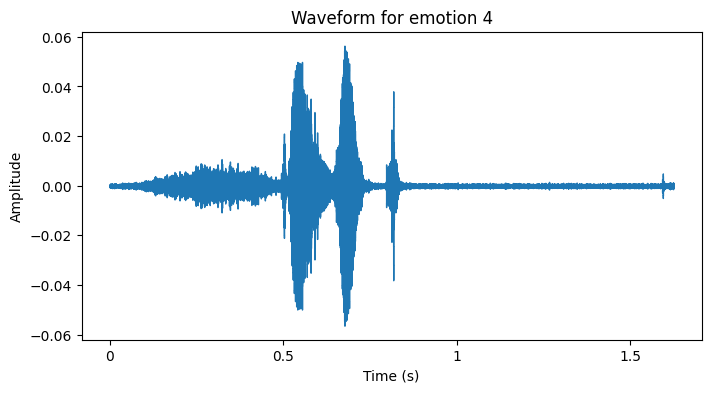

- Noise addition -
Antes: 5899
Después 6035
índice:  94


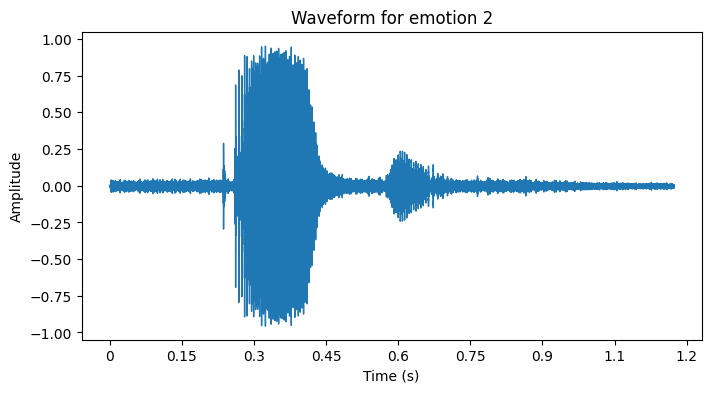

- Noise addition -
Antes: 6035
Después 6239
índice:  150


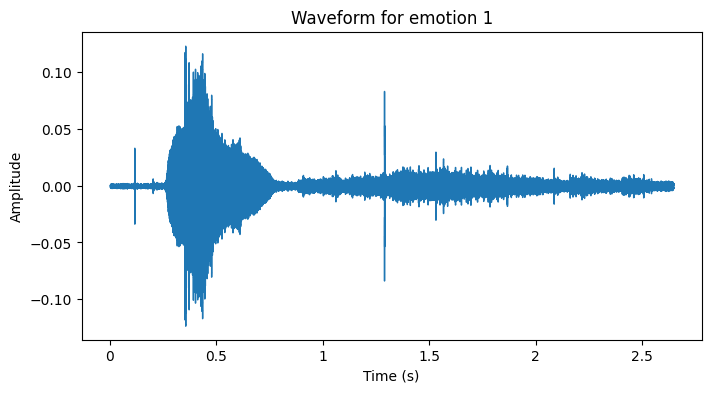

- Noise addition -
Antes: 6239
Después 6319
índice:  25


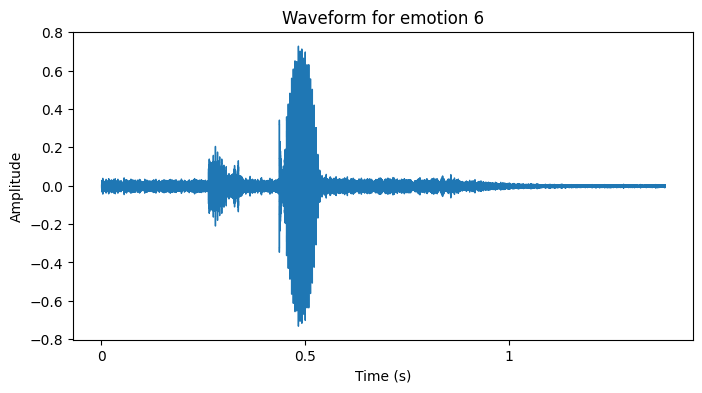

- Pitch-Shifting addition -
Antes: 6319
Después 6328
índice:  6


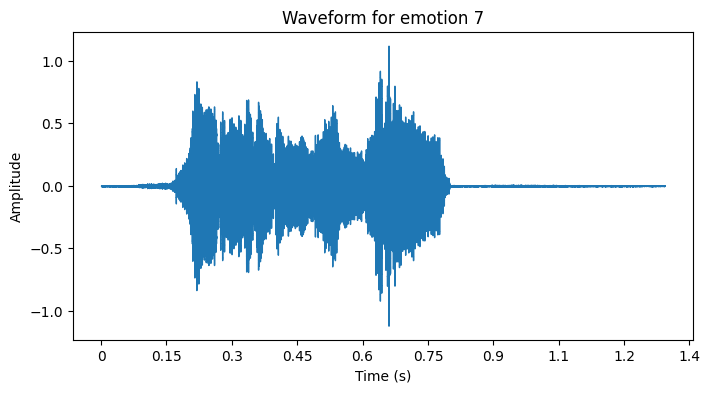

- Pitch-Shifting addition -
Antes: 6328
Después 6420
índice:  68


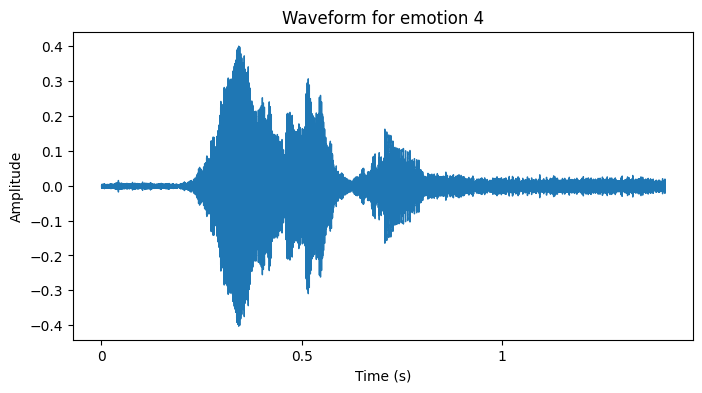

- Pitch-Shifting addition -
Antes: 6420
Después 6556
índice:  131


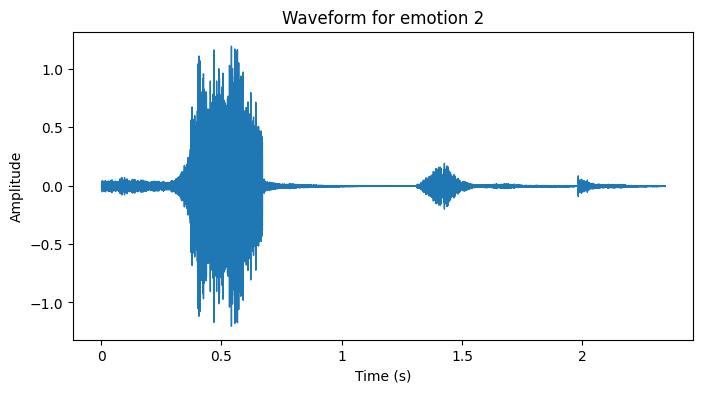

- Pitch-Shifting addition -
Antes: 6556
Después 6761
índice:  56


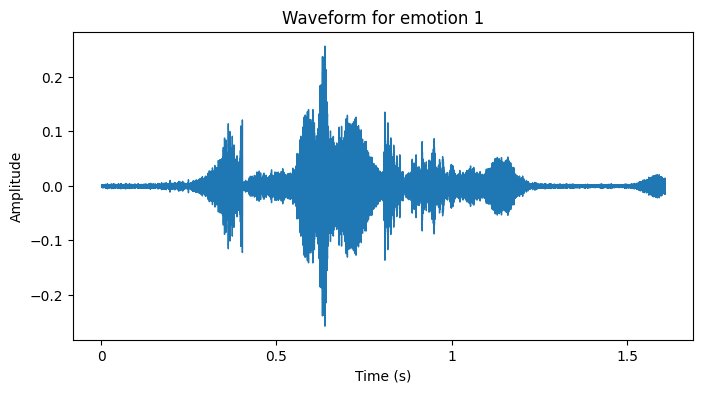

- Pitch-Shifting addition -
Antes: 6761
Después 6841
índice:  16


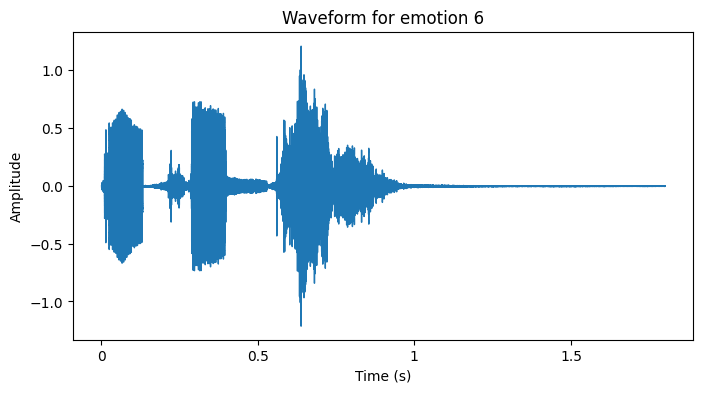

- Time stretching addition -
Antes: 6841
Después 6849
índice:  4


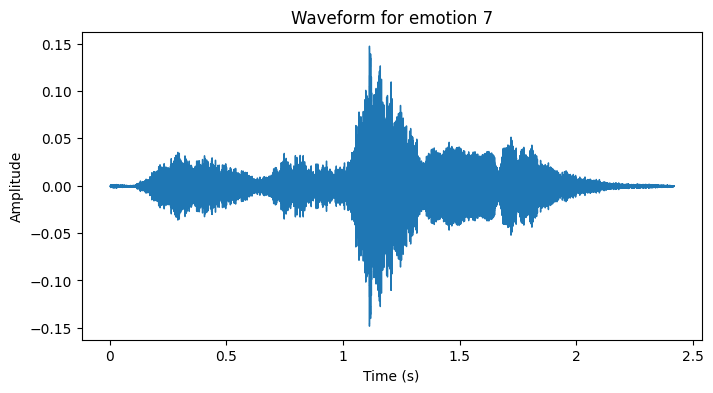

- Time stretching addition -
Antes: 6849
Después 6941
índice:  54


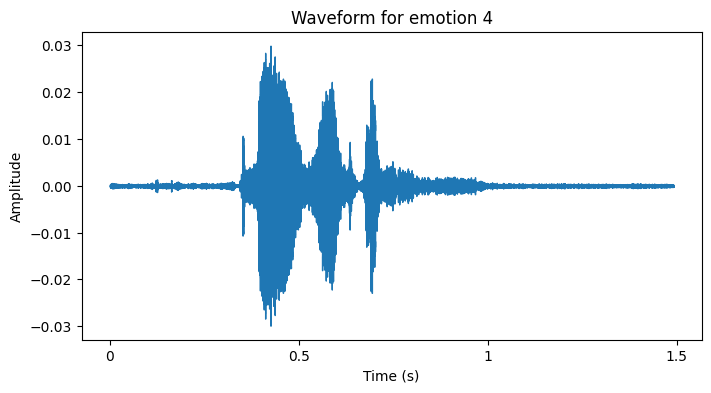

- Time stretching addition -
Antes: 6941
Después 7076
índice:  47


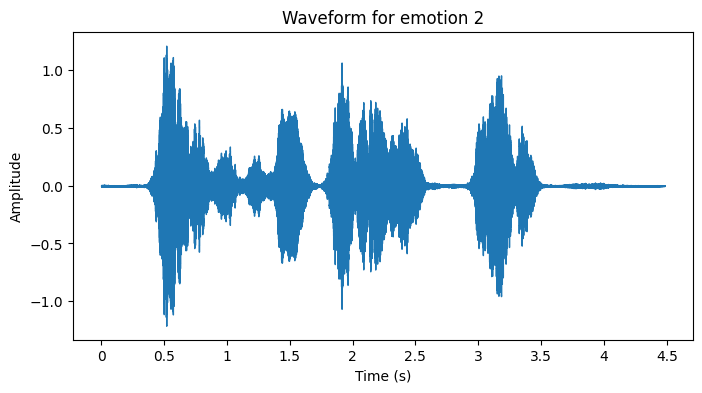

- Time stretching addition -
Antes: 7076
Después 7280
índice:  70


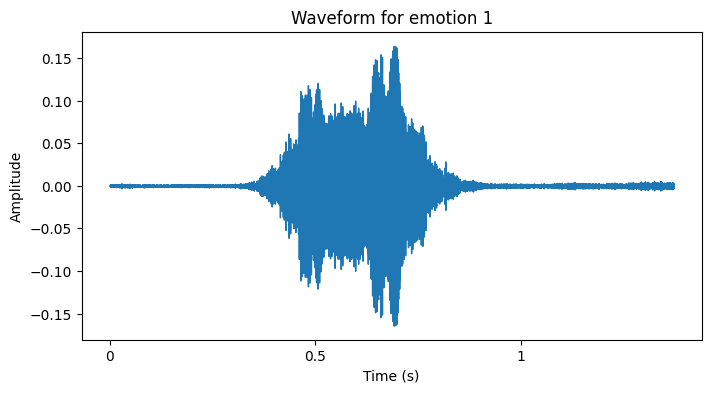

- Time stretching addition -
Antes: 7280
Después 7360
índice:  2


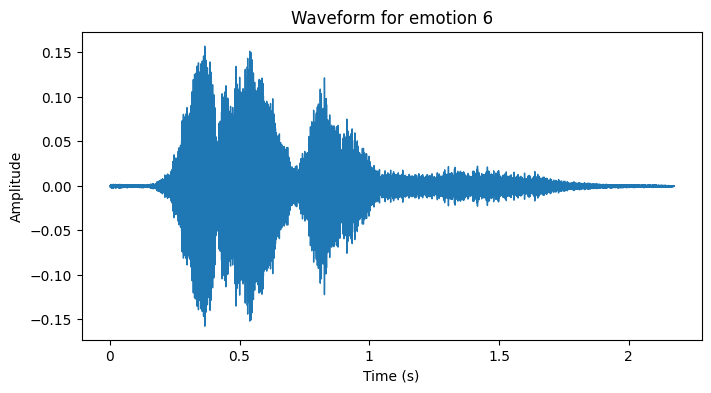

In [103]:
# N O I S E   A D D I T I O N
# 'ninguno' necesita 25/3 = 8.33da por técnica
ninguno_da = noise(ninguno_ds,8)
# Miedo: necesita 276/3 = 92 por técnica
miedo_da = noise(miedo_ds,92)
# Miedo: necesita 407/3 = 135.66 por técnica
enojo_da = noise(enojo_ds,136)
# Tristeza: necesita 613/3 = 204.33 por muestra
tristeza_da = noise(tristeza_ds,204)
# Desprecio: 240/3 = 80 por técnica
desprecio_da = noise(desprecio_ds,80)

# P I T C H   S H I F T I N G
ninguno_da = pitch_shift(ninguno_ds,9)
miedo_da = pitch_shift(miedo_ds,92)
enojo_da = pitch_shift(enojo_ds,136)
tristeza_da = pitch_shift(tristeza_ds,205)
desprecio_da = pitch_shift(desprecio_ds,80)

# T I M E   S T R E T C H I N G
ninguno_da = time_stretching(ninguno_ds,8)
miedo_da = time_stretching(miedo_ds,92)
enojo_da = time_stretching(enojo_ds,135)
tristeza_da = time_stretching(tristeza_ds,204)
desprecio_da = time_stretching(desprecio_ds,80)

## **Paso 4. Comprobar muestras**
Siempre es buena idea comprobar el estado del dataset

In [104]:
ilabels = [0, 1, 2, 3, 4, 5, 6, 7]
contador = [0,0,0,0,0,0,0,0]
for i in range(len(dataset['emotion'])):
  for j,emocion in enumerate(ilabels):
    if dataset['emotion'][i] == emocion:
      contador[j]+=1
print(contador)

[1000, 1000, 1000, 1000, 1000, 1000, 360, 1000]


In [105]:
from IPython.display import Audio

def display_random_samples(dataset,n,sampling_rate=sampling_rate):
  random_indices = np.random.choice(len(dataset['emotion']),n,replace=False)
  emotions = [dataset['emotion'][i] for i in random_indices]
  audios = [dataset['audio'][i] for i in random_indices]
  for i in range(len(audios)):
    plt.figure(figsize=(8,4))
    librosa.display.waveshow(audios[i],sr=sampling_rate)
    plt.title(f'Waveform for {emotions[i]} sample')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()
    display(Audio(audios[i],rate=sampling_rate))

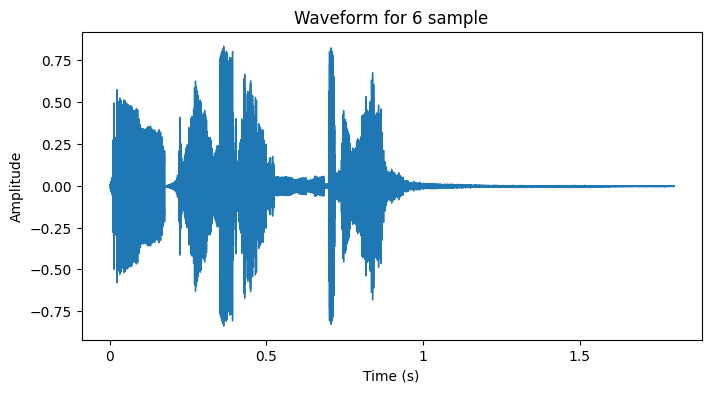

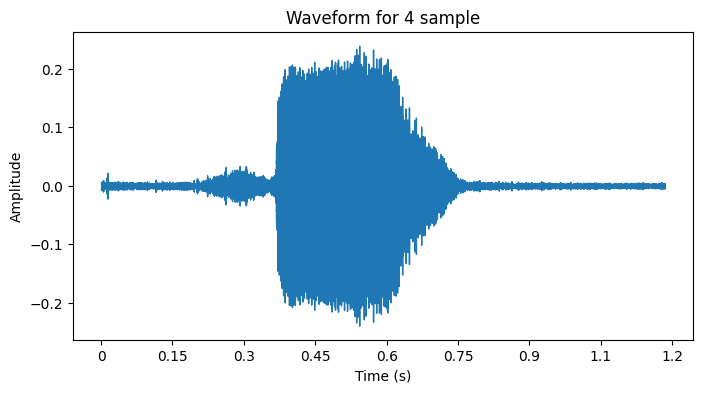

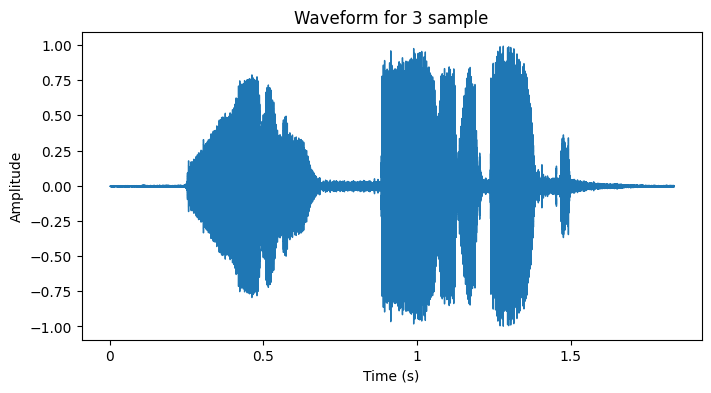

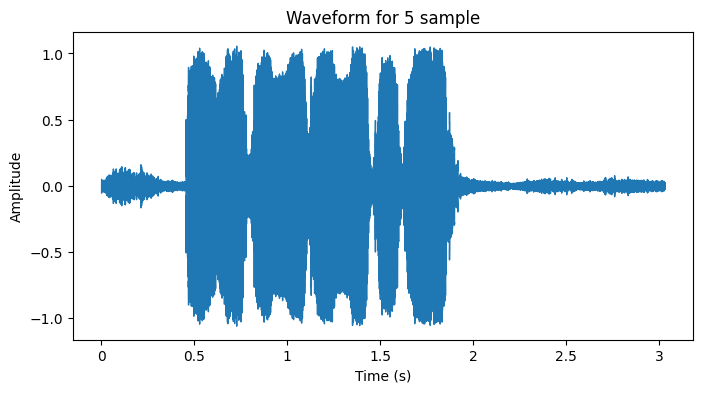

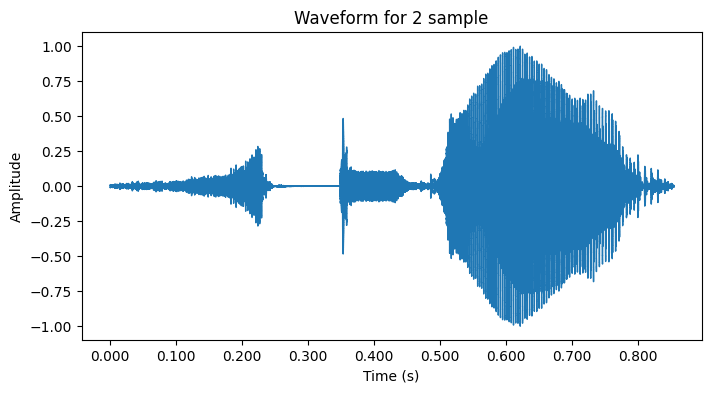

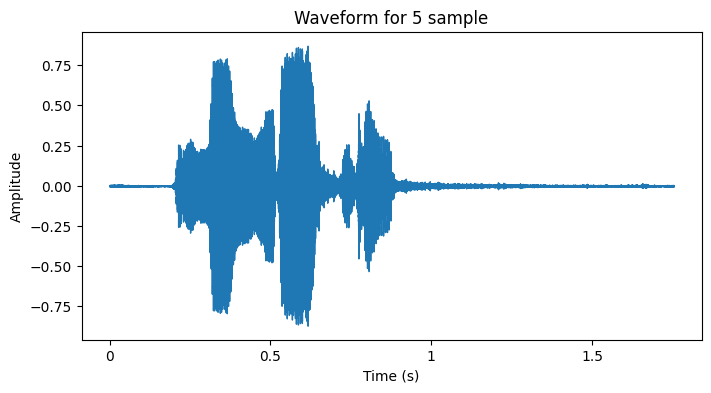

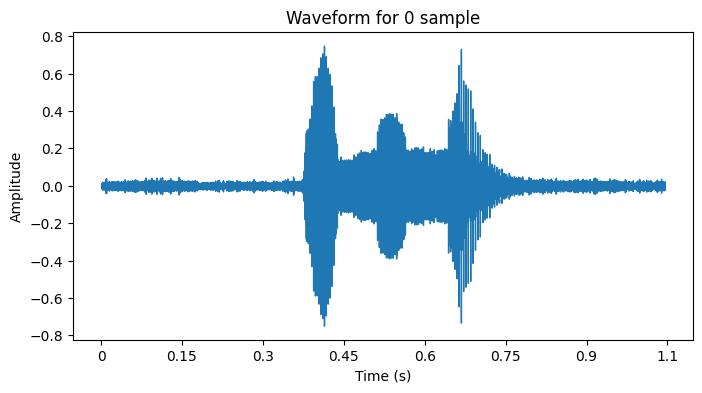

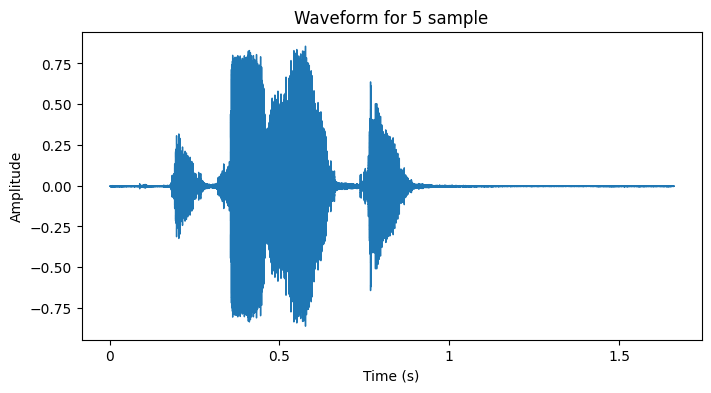

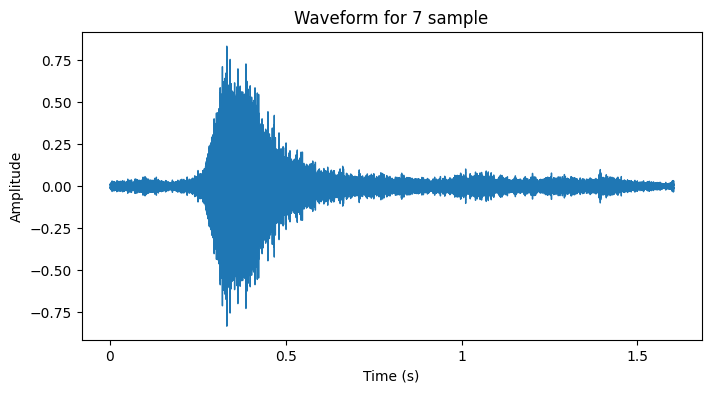

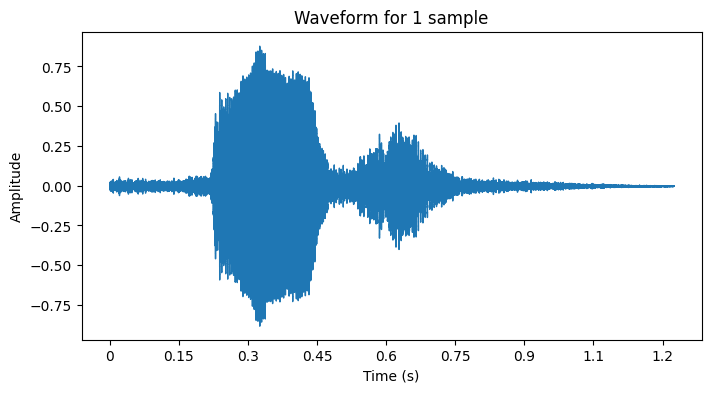

In [106]:
display_random_samples(dataset,10)

### **Normalizar tamaño de audios**

In [107]:
def fix_length(ds,target_length):
  fixed_dataset = {'audio':[], 'emotion':[]}

  for i, audio in enumerate(ds['audio']):
    audio_len = len(audio)

    # Si el audio es más grade que la medida objetivo, truncarlo
    if audio_len > target_length:
      fixed_dataset['audio'].append(audio[:target_length])
    # Si el audio es más pequeño que la lngitud objetivo, rellenar con 0's
    else:
      padding_length = target_length - audio_len
      audio_padded = np.pad(audio,(0,padding_length))
      fixed_dataset['audio'].append(audio_padded)
    fixed_dataset['emotion'].append(dataset['emotion'][i])

  #display_random_sample(fixed_dataset)
  return fixed_dataset

In [108]:
def check_audio_lengths(ds):
  lengths = [len(audio) for audio in ds['audio']]
  if len(set(lengths)) == 1:
    print(f'Todos los audios tienen longitud { lengths[0]}')
  else:
    print('Los audios tienen diferente longitud')

In [109]:
def get_average_length(ds):
  total_length = 0
  num_audios = len(ds['audio'])

  for audio in ds['audio']:
    audio_length = len(audio)
    total_length += audio_length

  average_length = total_length/num_audios
  return int(average_length)


In [110]:
check_audio_lengths(dataset)
average_length = get_average_length(dataset)
print(f'average length: ', average_length)

Los audios tienen diferente longitud
average length:  27606


In [111]:
fixed_dataset = fix_length(dataset,average_length)

In [112]:
check_audio_lengths(fixed_dataset)

Todos los audios tienen longitud 27606


In [113]:
def get_first_factor(average_length, first, last):
  for num in range(first,last):
    if average_length%num == 0:
      return num
  return get_first_factor(average_length, last,last+5)

In [114]:
num_frames = get_first_factor(average_length, 15, 25)
if num_frames:
  frame_size = average_length//num_frames
print(f'frame size {frame_size}')
print(f'number of frames { num_frames}')


frame size 642
number of frames 43


### **Extracción de características**

In [115]:
def feature_space_2D(ds, sampling_rate=sampling_rate, n_mels=128, n_fft=1569, hop_length=512):
  feature_space_2D = {'mel_spectrogram':[], 'emotions':[]}
  for i,audio, in enumerate(ds['audio']):
    mel_spec = librosa.feature.melspectrogram(y=audio,sr=sampling_rate, n_mels=n_mels,
                                              n_fft=n_fft, hop_length=hop_length)
    # Convert mel spectrogram to log scale
    mel_spec_db= librosa.power_to_db(mel_spec, ref=np.max)
    #mel_spec_3d = mel_spec_db.reshape(mel_spec_db.shape[0], mel_spec_db.shape[1],1)
    #feature_space_2D['mel_spectrogram].append(mel_spec_3d)
    feature_space_2D['mel_spectrogram'].append(mel_spec_db)
    feature_space_2D['emotions'].append(ds['emotion'][i])
  return feature_space_2D

In [116]:
feature_space_2d_dataset = feature_space_2D(fixed_dataset)

In [117]:
# Get the sahpes of the arrays
shapes = [arr.shape for arr in feature_space_2d_dataset['mel_spectrogram']]

# check if all shapes are equal
if all(shape == shapes[0] for shape in shapes):
  print(f'The arrays have the same number of elements {shapes[0]}')
else:
  print('The arrays have different numbers of elements')

The arrays have the same number of elements (128, 54)


In [118]:
a = np.array(feature_space_2d_dataset['emotions'])
print(a.shape)

(7360,)


In [119]:
len(feature_space_2d_dataset['mel_spectrogram'])

7360

In [120]:
def display_random_samples_spectrogram(feature_space_2D_dataset,n,sampling_rate=sampling_rate) :
  random_indices = np.random.choice(len(feature_space_2D_dataset["mel_spectrogram"]),n, replace=False)
  emotions = [feature_space_2D_dataset["emotions"][i] for i in random_indices]
  mel_spectrograms = [feature_space_2D_dataset["mel_spectrogram"][i] for i in random_indices]
  for i in range(len(mel_spectrograms)):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrograms[i], sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram - Emotion: {emotions[i]}")
    plt.show()

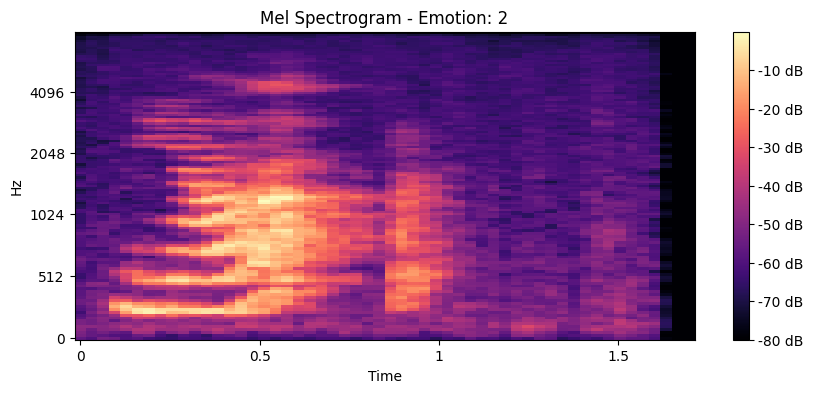

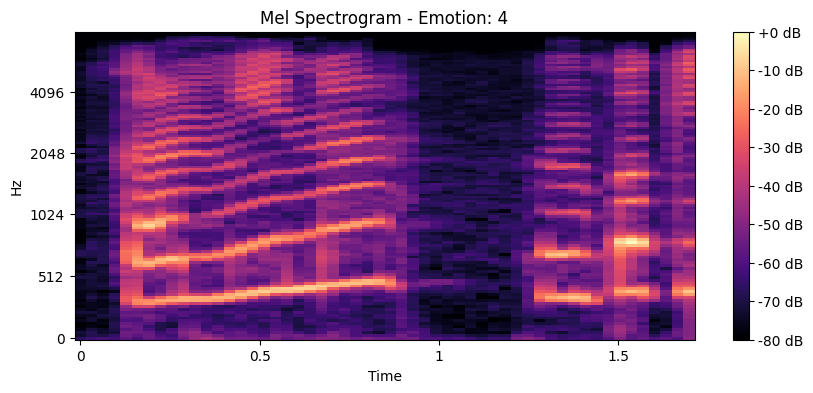

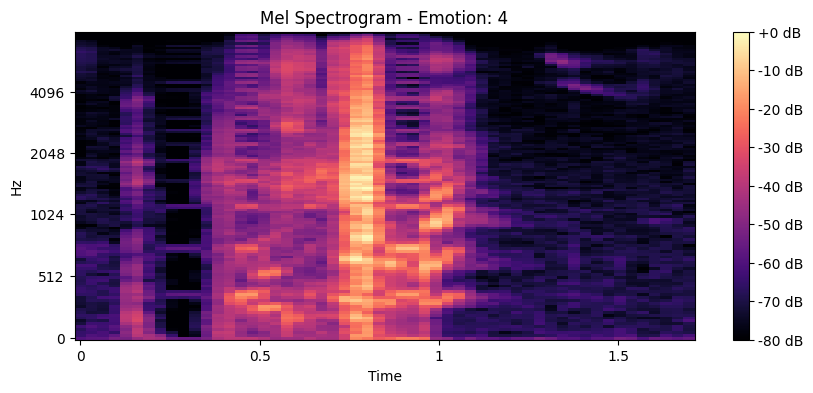

In [121]:
display_random_samples_spectrogram(feature_space_2d_dataset,3)

**Label Encoding**


In [122]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(feature_space_2d_dataset['emotions'])
encoded_emotions = to_categorical(encoded_emotions,num_classes=8)
# Get original_labels = label_encoder.classes_
original_labels = label_encoder.classes_
print(len(encoded_emotions))
print(encoded_emotions)
print(original_labels)

7360
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[0 1 2 3 4 5 6 7]


In [123]:
from sklearn.model_selection import train_test_split
def split_data(x, encoded_emotion):
  # split the data into training and validation (70%) and testing (30%)
  X_train_val, X_test, y_train_val, y_test = train_test_split(
     x, encoded_emotions,
      test_size=0.1, random_state=42,stratify=encoded_emotions)
  # split the training and validation data into training and validation sets (95% and 5%)
  X_train, X_val, y_train, y_val = train_test_split(
      X_train_val, y_train_val, test_size=0.1, random_state=42,
      stratify=y_train_val)
  # convert the lists of features and labels to numpy arrays
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  # print the shapes of the datasets
  print("Training data shape:", X_train.shape)
  print("Validation data shape:", X_val.shape)
  print("Testing data shape:", X_test.shape)
  print("Training labels shape:", y_train.shape)
  print("Validation labels shape:", y_val.shape)
  print("Testing labels shape:", y_test.shape)
  return X_train,X_val,X_test,y_train,y_val,y_test

In [124]:
X_train,X_valid,X_test,y_train,y_valid,y_test = split_data(np.arange(0, len(encoded_emotions), 1), encoded_emotions)


Training data shape: (5961,)
Validation data shape: (663,)
Testing data shape: (736,)
Training labels shape: (5961, 8)
Validation labels shape: (663, 8)
Testing labels shape: (736, 8)


# **MODELOS CNN 2D-LSTM**

In [125]:
feature_2D = np.array(feature_space_2d_dataset["mel_spectrogram"])
X_train_2D = feature_2D[X_train,:,:]
X_valid_2D = feature_2D[X_valid,:]
X_test_2D = feature_2D[X_test,:]
y_train_2D = y_train
y_valid_2D = y_valid
y_test_2D = y_test

In [126]:
print(X_train_2D.shape)
print(X_test_2D.shape)

(5961, 128, 54)
(736, 128, 54)


In [127]:
X_train_m1 = X_train_2D
X_valid_m1 = X_valid_2D
X_test_m1 = X_test_2D
y_train_m1 = y_train_2D
y_valid_m1 = y_valid_2D
y_test_m1 = y_test_2D

### **Modelo V1**
---
Simple

In [128]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def build_2D_model1(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, epochs, verbose) :
    X_train_2D = np.reshape(X_train_2D, (X_train_2D.shape[0], X_train_2D.shape[1], X_train_2D.shape[2], 1))
    input_shape_2D = X_train_2D[0].shape

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape_2D))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=8, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-4,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)

    model.fit(X_train_2D, y_train_2D, epochs=epochs, verbose=verbose, validation_data=(X_valid_2D, y_valid_2D), callbacks=[monitor])
    return model

In [129]:
model1 = build_2D_model1(X_train_m1,X_valid_m1,y_train_m1,y_valid_m1, 30, 1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 122, 48, 32)       1600      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 61, 24, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_11 (Ba  (None, 61, 24, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 59, 22, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 29, 11, 64)        0         
 ng2D)                                                           
                                                      

In [130]:
predicted_emotions_2D_ = model1.predict(X_test_m1)

23/23 [==============================] - 0s 3ms/step


In [131]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def calculate_accuracy(predicted_emotions, true_emotions):
  # Get the predicted classes and true classes
  predicted_classes = np.argmax(predicted_emotions, axis=1)
  true_classes = np.argmax(true_emotions, axis=1)

  # Calculate the accuracy
  accuracy = accuracy_score(true_classes, predicted_classes)

  # Calculate the F1-score
  f1 = f1_score(true_classes, predicted_classes, average='weighted')

  # Create the confusion matrix
  confusion = confusion_matrix(true_classes, predicted_classes)

  return accuracy*100,f1,confusion

In [132]:
accuracy_model1,f1_model1,confusion_model1 = calculate_accuracy(predicted_emotions_2D_,y_test_m1)

In [133]:
print(f"test accuracy 2D: {accuracy_model1}")
print(f"test f1_score 2D: {f1_model1}")
print("confusion matrix for model1 test data")
print(confusion_model1)

test accuracy 2D: 45.380434782608695
test f1_score 2D: 0.4511340538974605
confusion matrix for model1 test data
[[28  4  8 10 14 20  2 14]
 [ 8 65  6  2  8  2  0  9]
 [10  2 47 11 11  6  1 12]
 [10  2 15 50  8  2  3 10]
 [ 8  6  2  3 57 10  1 13]
 [26  5  7 15 13 21  2 11]
 [ 2  2  6  1  3  0 17  5]
 [11  5 10 11  6  8  0 49]]


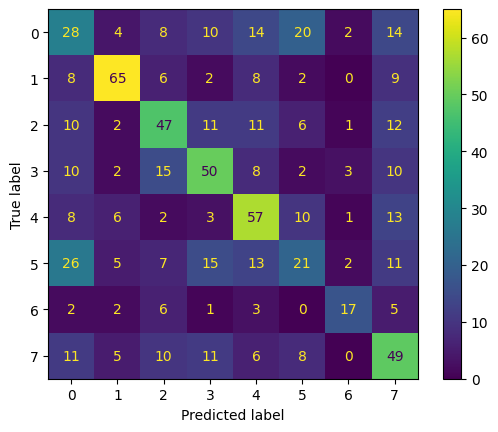

In [134]:
cm_display_2D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_model1, display_labels = original_labels)
cm_display_2D_.plot()
plt.show()

### **Modelo V2**
---
Simple agregando LSTM

In [135]:
from keras.layers import LSTM, Reshape
def build_2D_model2(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, epochs, verbose) :
  X_train_2D = np.reshape(X_train_2D, (X_train_2D.shape[0], X_train_2D.shape[1], X_train_2D.shape[2], 1))
  input_shape_2D = X_train_2D[0].shape

  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape_2D))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.35))

  model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Reshape((-1,128)))
  model.add(LSTM(128, return_sequences=False))

  model.add(Flatten())
  model.add(Dense(units=256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=8, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics='accuracy')
  model.summary()

  monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-4,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)

  model.fit(X_train_2D, y_train_2D, epochs=epochs, verbose=verbose, validation_data=(X_valid_2D, y_valid_2D), callbacks=[monitor])
  return model

In [136]:
X_train_m2 = X_train_2D
X_valid_m2 = X_valid_2D
X_test_m2 = X_test_2D
y_train_m2 = y_train_2D
y_valid_m2 = y_valid_2D
y_test_m2 = y_test_2D

In [137]:
model2 = build_2D_model2(X_train_m2,X_valid_m2,y_train_m2,y_valid_m2, 30, 1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 52, 32)       320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 63, 26, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 63, 26, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_17 (Dropout)        (None, 63, 26, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 24, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 30, 12, 64)       

In [138]:
predicted_emotions_2D_ = model2.predict(X_test_m2)

23/23 [==============================] - 1s 4ms/step


In [139]:
accuracy_model2,f1_model2,confusion_model2 = calculate_accuracy(predicted_emotions_2D_,y_test_m2)

In [140]:
print(f"test accuracy 2D: {accuracy_model2}")
print(f"test f1_score 2D: {f1_model2}")
print("confusion matrix for model2 test data")
print(confusion_model2)

test accuracy 2D: 35.59782608695652
test f1_score 2D: 0.3253205878952324
confusion matrix for model2 test data
[[10  4  2 17 19 39  0  9]
 [ 0 54 14  5 13  4  0 10]
 [ 3  9 26 27  8 19  0  8]
 [ 4  1  9 72  2 12  0  0]
 [ 4 31 13  5 21 20  0  6]
 [ 7  8  1 13 18 49  0  4]
 [ 0 20  5  1  6  1  0  3]
 [ 4 13  7 18 12 16  0 30]]


In [141]:
print(f"test accuracy 2D: {accuracy_model2}")
print(f"test f1_score 2D: {f1_model2}")
print("confusion matrix for model2 test data")
print(confusion_model2)

test accuracy 2D: 35.59782608695652
test f1_score 2D: 0.3253205878952324
confusion matrix for model2 test data
[[10  4  2 17 19 39  0  9]
 [ 0 54 14  5 13  4  0 10]
 [ 3  9 26 27  8 19  0  8]
 [ 4  1  9 72  2 12  0  0]
 [ 4 31 13  5 21 20  0  6]
 [ 7  8  1 13 18 49  0  4]
 [ 0 20  5  1  6  1  0  3]
 [ 4 13  7 18 12 16  0 30]]


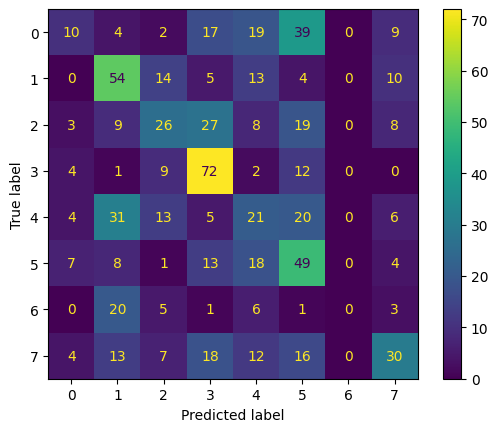

In [142]:
cm_display_2D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_model2, display_labels = original_labels)
cm_display_2D_.plot()
plt.show()

### **Modelo V3**
---
Enchanced with Deeper Architecture and Fine-Tuned Dropout

In [143]:
def build_2D_model3(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, epochs, verbose) :
  X_train_2D = np.reshape(X_train_2D, (X_train_2D.shape[0], X_train_2D.shape[1], X_train_2D.shape[2], 1))
  input_shape_2D = X_train_2D[0].shape
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape_2D))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0,4))

  model.add(Reshape((-1,128)))
  model.add(LSTM(128, return_sequences=True))
  model.add(LSTM(64, return_sequences=False))

  model.add(Flatten())
  model.add(Dense(units=512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=8, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics='accuracy')
  model.summary()

  monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-4,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)

  model.fit(X_train_2D, y_train_2D, epochs=epochs, verbose=verbose, validation_data=(X_valid_2D, y_valid_2D), callbacks=[monitor])
  return model

In [144]:
X_train_m3 = X_train_2D
X_valid_m3 = X_valid_2D
X_test_m3 = X_test_2D
y_train_m3 = y_train_2D
y_valid_m3 = y_valid_2D
y_test_m3 = y_test_2D

In [145]:
model3 = build_2D_model3(X_train_m3,X_valid_m3,y_train_m3,y_valid_m3, 30, 1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 124, 50, 32)       832       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 62, 25, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_15 (Ba  (None, 62, 25, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 62, 25, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 60, 23, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 30, 11, 64)       

In [146]:
predicted_emotions_2D_ = model3.predict(X_test_m3)

23/23 [==============================] - 1s 7ms/step


In [147]:
accuracy_model3,f1_model3,confusion_model3 = calculate_accuracy(predicted_emotions_2D_,y_test_m3)

In [148]:
print(f"test accuracy 2D: {accuracy_model3}")
print(f"test f1_score 2D: {f1_model3}")
print("confusion matrix for model3 test data")
print(confusion_model3)

test accuracy 2D: 41.84782608695652
test f1_score 2D: 0.40687849499414613
confusion matrix for model3 test data
[[25 11  3 12  3 41  0  5]
 [ 6 71  3  1  9  7  1  2]
 [ 6  9 36 23  5 14  2  5]
 [ 6  1  8 71  3  9  0  2]
 [20 28  5  2 21 20  1  3]
 [17 10  3 13 13 41  0  3]
 [ 4  5  8  1  2  1 10  5]
 [ 8 12  3 15  7 19  3 33]]


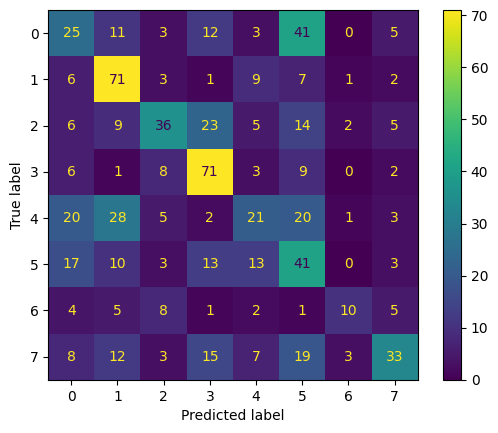

In [149]:
cm_display_2D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_model3, display_labels = original_labels)
cm_display_2D_.plot()
plt.show()

### **Modelo V4**
---
Complex with Bidirectional LSTM and Adjusted Filters

In [150]:
from keras.layers import Bidirectional

def build_2D_model4(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, epochs, verbose) :
  X_train_2D = np.reshape(X_train_2D, (X_train_2D.shape[0], X_train_2D.shape[1], X_train_2D.shape[2], 1))
  input_shape_2D = X_train_2D[0].shape
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape_2D))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=4, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=256, kernel_size=2, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0,4))

  model.add(Reshape((-1,256)))
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Bidirectional(LSTM(64, return_sequences=False)))

  model.add(Flatten())
  model.add(Dense(units=1024, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(units=8, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics='accuracy')
  model.summary()

  monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-4,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)

  model.fit(X_train_2D, y_train_2D, epochs=epochs, verbose=verbose, validation_data=(X_valid_2D, y_valid_2D), callbacks=[monitor])
  return model

In [151]:
X_train_m4 = X_train_2D
X_valid_m4 = X_valid_2D
X_test_m4 = X_test_2D
y_train_m4 = y_train_2D
y_valid_m4 = y_valid_2D
y_test_m4 = y_test_2D

In [152]:
model4 = build_2D_model4(X_train_m4,X_valid_m4,y_train_m4,y_valid_m4, 30, 1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 124, 50, 32)       832       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 62, 25, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 62, 25, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_25 (Dropout)        (None, 62, 25, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 59, 22, 128)       65664     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 29, 11, 128)     

In [153]:
predicted_emotions_2D_ = model4.predict(X_test_m4)

23/23 [==============================] - 2s 9ms/step


In [154]:
accuracy_model4,f1_model4,confusion_model4 = calculate_accuracy(predicted_emotions_2D_,y_test_m4)

In [155]:
print(f"test accuracy 2D: {accuracy_model4}")
print(f"test f1_score 2D: {f1_model4}")
print("confusion matrix for model1 test data")
print(confusion_model4)

test accuracy 2D: 43.47826086956522
test f1_score 2D: 0.4341205506309607
confusion matrix for model1 test data
[[51  3  2 12  3 24  2  3]
 [17 58  5  0 10  3  2  5]
 [13  4 34 21  5 15  0  8]
 [ 7  2 10 66  2 12  0  1]
 [27 20  4  2 29 10  3  5]
 [36  2  9  9  8 31  1  4]
 [ 8  5  2  1  2  1 11  6]
 [17  5  6 13  5 14  0 40]]


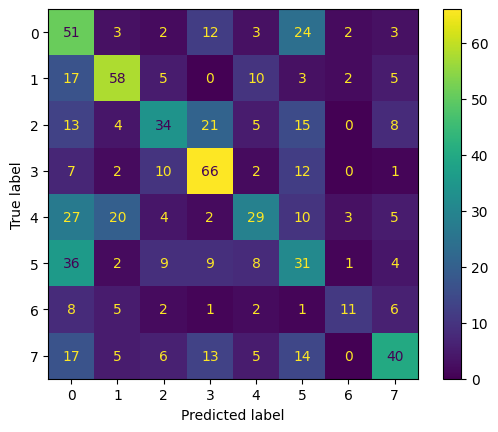

In [156]:
cm_display_2D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_model4, display_labels = original_labels)
cm_display_2D_.plot()
plt.show()